**Christian Charles D. Cambri**  \
**COE 005-ECE41S11**

Import all the important libraries, modules, and other part for this particular code in order to execute and show the output of the game.

In [1]:
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
tcmalloc: large alloc 1821458432 bytes == 0x2350000 @  0x7f60e4e3a1e7 0x4b2590 0x5ad01c 0x5dcfef 0x58f92b 0x590c33 0x5e48ac 0x4d20fa 0x51041f 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x4bad0a 0x4d3249
tcmalloc: large alloc 1821458432 bytes == 0x6ec64000 @  0x7f60e4e3a1e7 0x4b2590 0x5ad01c 0x64b047 0x4d22a6 0x51041f 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6
tcmalloc: large alloc 1821458432 bytes == 0xdb

Import the game, the Joypad wrapper, SIMPLIFIED controls and other libraries and algorithms needed which would be crucial for the game.

In [2]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

Data Preprocessing
Data Preprocessing includes game setup, creating the base environment, simplifying the controls, grayscales and stack the frames.

In [3]:
env = gym_super_mario_bros.make('SuperMarioBros2-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros2-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [5]:
state = env.reset()

In [6]:
state, reward, done, info = env.step([5])

Plotting the environment, in order to give the idea on how it would look like.

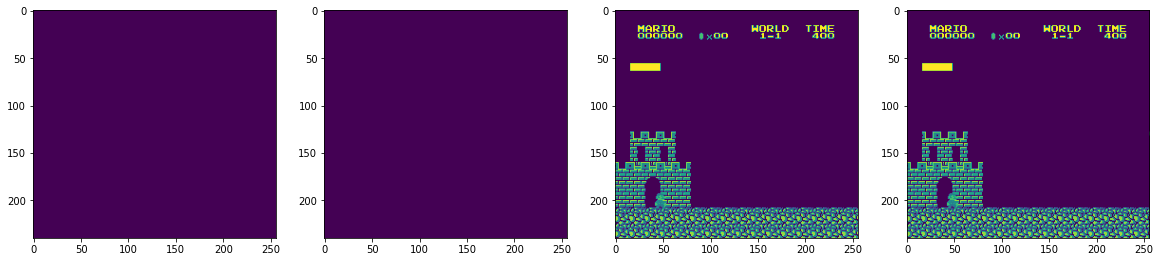

In [7]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

Creating and Training the Model


In [8]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [9]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

Configuring the model saving callback

In [10]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

This is the initial AI model

In [11]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


Using the CPU Device
We can now add a VecTransposeImage to the environment.

In [12]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000, callback=callback)

Logging to ./logs/PPO_3


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 22  |
|    iterations      | 1   |
|    time_elapsed    | 23  |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 8            |
|    iterations           | 2            |
|    time_elapsed         | 122          |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 8.849893e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.00314     |
|    learning_rate        | 1e-06        |
|    loss                 | 183          |
|    n_updates            | 10           |
|    policy_gradient_loss | -7.34e-05    |
|    value_loss           | 404          |
------------------------------------------


In [13]:
model.save('CAMBRI_MODEL')

MODEL TESTING - In the timestep, I've setup the timesteps to 1000, since collab only supports limited runs when using GPU, 1000 timesteps is just a testing which would've been better if we can use 500,000 to 1,000,000 timesteps for a more accurate run and more learning steps for the AI. 

Next is to Import the model

In [14]:
model = PPO.load('/content/train/best_model_1000.zip')

In [15]:
state = env.reset()

After Importing the model, we'll now setup the recording agent for the game while the AI operates the game.

In [16]:
from gym import wrappers

env = gym_super_mario_bros.make('SuperMarioBros2-v1')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(4000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done: break
env.close()

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Here is we're the we show the video on how an AI learn to play a game which is the Super Mario Bros 2.

In [17]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

Short Discussion:
This AI learning to play Super Mario Bros is executed using Google Colab, I only use 1,000 particular trainsteps in order to make it run in Google Colab since Google Colab only allows limited usage of GPU which is a dowside in using Colab, but atleast we get to see a glimpse on how AI learns on playing games and how it functions compared to a human playing the game.

Coedes and Materials References: \

Tutorial on how to display Super Mario Bros on Google Colab:   \
https://github.com/openai/gym/issues/2560   \
Super Mario Bros. for OpenAI Gym:   \
https://pypi.org/project/gym-super-mario-bros/ \
ipynb file for Super Maruo Bros tutorial:   \
https://github.com/nicknochnack/MarioRL \
Tutorial on how to install nes-py 8.2.1: \
https://pypi.org/project/nes-py/ \